In [125]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.16.2
1 Physical GPUs, 1 Logical GPUs


In [17]:
# clean for debug purpose only 

trainData = None
valData = None
testData = None

for layer in model.layers:
	if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'kernel'):
		layer.kernel.assign(layer.kernel_initializer(layer.kernel.shape, dtype=layer.kernel.dtype))
	if hasattr(layer, 'bias_initializer') and hasattr(layer, 'bias'):
		layer.bias.assign(layer.bias_initializer(layer.bias.shape, dtype=layer.bias.dtype))

tf.keras.backend.clear_session(free_memory=True)


TypeError: clear_session() got an unexpected keyword argument 'free_memory'

# Loading the data

Since there were multiple labels, I decided to write a custom import for the images and labels.

The custom import allowed me to load and identify the class imbalances of the dataset. 

In [126]:
# load images and labels 
from collections import Counter
import csv

imageFileNames = tf.data.Dataset.list_files('./images/*', shuffle=False)

allLabelDict = {}

numTrainImages = 0
labelDict = Counter()
cellShapeDict = Counter()
nucleusShapeDict = Counter()
cytoplasmVacuoleDict = Counter()

# loads the labels from the csv 
with open("./dev_data_2025.csv", "r") as f:
	csvItems = list(csv.DictReader(f))
	for imgLabel in csvItems:
		numTrainImages += 1
		labelDict[imgLabel['label']] += 1
		cellShapeDict[imgLabel['cell_shape']] += 1
		nucleusShapeDict[imgLabel['nucleus_shape']] += 1
		cytoplasmVacuoleDict[imgLabel['cytoplasm_vacuole']] += 1

	labelTuple = tuple(labelDict.keys())
	cellShapeTuple = tuple(cellShapeDict.keys())
	nucleusShapeTuple = tuple(nucleusShapeDict.keys())
	cytoplasmVacuoleTuple = tuple(cytoplasmVacuoleDict.keys())
	
	for imgLabel in csvItems:
		allLabelDict[imgLabel['imageID']] = [
			labelTuple.index(imgLabel['label']), 
			cellShapeTuple.index(imgLabel['cell_shape']), 
			nucleusShapeTuple.index(imgLabel['nucleus_shape']), 
			cytoplasmVacuoleTuple.index(imgLabel['cytoplasm_vacuole'])
		]

# A weighting for the classes to help prevent over fitting to over represented classes 
classWeights = {
	'label': np.array([(1 / labelDict[labelTuple[i]]) * (numTrainImages / 2.0) for i in range(len(labelTuple))]),
	'cellShape': np.array([(1 / cellShapeDict[cellShapeTuple[i]]) * (numTrainImages / 2.0) for i in range(len(cellShapeTuple))]),
	'nucleusShape': np.array([(1 / nucleusShapeDict[nucleusShapeTuple[i]]) * (numTrainImages / 2.0) for i in range(len(nucleusShapeTuple))]),
	'cytoplasmVacuole': np.array([(1 / cytoplasmVacuoleDict[cytoplasmVacuoleTuple[i]]) * (numTrainImages / 2.0) for i in range(len(cytoplasmVacuoleTuple))])
}

# Estimate the accuracy of a model maKing random guesses  
classRandomAcc = {
	'label': sum([(i / numTrainImages)**2 for i in labelDict.values()]),
	'cellShape': sum([(i / numTrainImages)**2 for i in cellShapeDict.values()]),
	'nucleusShape': sum([(i / numTrainImages)**2 for i in nucleusShapeDict.values()]),
	'cytoplasmVacuole': sum([(i / numTrainImages)**2 for i in cytoplasmVacuoleDict.values()])
}

print(f'label class imbalance in %: {[f"{key}: {value / 50}" for key, value in labelDict.items()]} | target % {100 / len(labelDict)}')
print(f'label class weights: {classWeights["label"]} | random guess accuracy {classRandomAcc["label"]}')
print(f'cell shape class imbalance in %: {[f"{key}: {value / 50}" for key, value in cellShapeDict.items()]} | target % {100 / len(cellShapeDict)}')
print(f'cell shape class weights: {classWeights["cellShape"]} | random guess accuracy {classRandomAcc["cellShape"]}')
print(f'nucleus shape class imbalance in %: {[f"{key}: {value / 50}" for key, value in nucleusShapeDict.items()]} | target % {100 / len(nucleusShapeDict)}')
print(f'nucleus shape class weights: {classWeights["nucleusShape"]} | random guess accuracy {classRandomAcc["nucleusShape"]}')
print(f'cytoplasm vacuole class imbalance in %: {[f"{key}: {value / 50}" for key, value in cytoplasmVacuoleDict.items()]} | target % {100 / len(cytoplasmVacuoleDict)}')
print(f'cytoplasm vacuole class weights: {classWeights["cytoplasmVacuole"]} | random guess accuracy {classRandomAcc["cytoplasmVacuole"]}')


label class imbalance in %: ['Lymphocyte: 11.58', 'Monocyte: 13.58', 'Basophil: 12.56', 'Neutrophil: 32.2', 'Eosinophil: 30.08'] | target % 20.0
label class weights: [4.31778929 3.68188513 3.98089172 1.55279503 1.66223404] | random guess accuracy 0.24179128
cell shape class imbalance in %: ['round: 78.08', 'irregular: 21.92'] | target % 50.0
cell shape class weights: [0.64036885 2.2810219 ] | random guess accuracy 0.65769728
nucleus shape class imbalance in %: ['unsegmented-round: 10.32', 'unsegmented-indented: 12.98', 'irregular: 8.58', 'segmented-multilobed: 12.52', 'unsegmented-band: 25.8', 'segmented-bilobed: 29.8'] | target % 16.666666666666668
nucleus shape class weights: [4.84496124 3.85208012 5.82750583 3.99361022 1.9379845  1.67785235] | random guess accuracy 0.20590296
cytoplasm vacuole class imbalance in %: ['no: 92.78', 'yes: 7.22'] | target % 50.0
cytoplasm vacuole class weights: [0.53890925 6.92520776] | random guess accuracy 0.8660256799999999


## Creating the tensorflow dataset

Now that I had the data I needed to create the tensorflow dataset that supports multiple labels because the model will need to classify multiple classes.

I used the map function on the image files already imported to load the Images into [360, 360, 3] tensors and then I added the labels generated above. 

The labels needed to be in the form of a dict for the loss function to read them correctly but `py_function` only returns tensors so I had to add an extra function to convert the labels again. 

To improve the training I added some basic data augmentation that randomizes the orientation of the images used for training. 
I chose to only change the orientation because other factors liKe brightness and contrast was fairly consistent across the whole dataset due to the fact that the cell imaging machine produced fairly uniform brightness images.      

In [127]:
def getLabel(path):
	path = path.numpy().decode("utf-8")
	Key = os.path.basename(path)[:9]
	
	if Key not in allLabelDict:
		print("Missing Key:", Key)
		raise ValueError("Missing label Key.")
	return tf.convert_to_tensor(allLabelDict[Key])

def getImage(path):
	img = tf.io.read_file(path)
	img = tf.io.decode_jpeg(img, channels=3)
	return tf.image.resize_with_crop_or_pad(img, 360, 360)

def processData(file_path):
	label = tf.py_function(func=getLabel, inp=[file_path], Tout=tf.int32)
	label.set_shape([4])

	img = tf.py_function(func=getImage, inp=[file_path], Tout=tf.uint8)
	img.set_shape([360, 360, 3])

	return img, label

def labelsToDict(img, label):
	labelDict = {
		"labelOutput": tf.convert_to_tensor([label[0]]),
    "cellShapeOutput": tf.convert_to_tensor([label[1]]),
    "nucleusShapeOutput": tf.convert_to_tensor([label[2]]),
    "cytoplasmVacuoleOutput": tf.convert_to_tensor([label[3]])
	}

	return img, labelDict

def augmentFn(img):
	img = tf.image.random_flip_left_right(img)
	img = tf.image.random_flip_left_right(img)
	return img

def augment(img, label):
	img = tf.py_function(func=augmentFn, inp=[img], Tout=tf.uint8)
	img.set_shape([360, 360, 3])

	return img, label


valSize = int(numTrainImages * 0.2)
batchSize = 10

trainData = imageFileNames \
  .skip(valSize) \
	.take(numTrainImages - valSize) \
  .map(processData, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(labelsToDict, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(augment, num_parallel_calls=tf.data.AUTOTUNE) \
  .batch(batchSize) \
	.cache() \
  .prefetch(buffer_size=tf.data.AUTOTUNE) 
	
valData = imageFileNames \
  .take(valSize) \
  .map(processData, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(labelsToDict, num_parallel_calls=tf.data.AUTOTUNE) \
  .batch(batchSize) \
	.cache() \
  .prefetch(buffer_size=tf.data.AUTOTUNE) 

testData = imageFileNames \
	.skip(numTrainImages) \
	.map(getImage, num_parallel_calls=tf.data.AUTOTUNE) \
	.batch(batchSize) \
	.cache() \
  .prefetch(buffer_size=tf.data.AUTOTUNE) 

print(f"train data size {tf.data.experimental.cardinality(trainData).numpy() * batchSize}")
print(f"val data size {tf.data.experimental.cardinality(valData).numpy() * batchSize}")
print(f"test data size {tf.data.experimental.cardinality(testData).numpy() * batchSize}")


train data size 4000
val data size 1000
test data size 5300


## The model 

I chose to use the convocational layers from VGG16 as a base and then I started by adding a standard pooling layer followed by a 64 wide dense layer.
The model had to classify 4 different labels so I needed 4 different output layers label, cell shape, nucleus shape and cytoplasm vacuole. 


In [128]:
# input and rescale
inputLayer = tf.keras.layers.Input(shape=(360, 360, 3))
inputRescale = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputLayer)

# imagenet pre made model
baseModel = tf.keras.applications.VGG16(
    weights='imagenet',  
    input_shape=(360, 360, 3),
    include_top=False
)
baseModel.trainable = False
convoLayers = baseModel(inputRescale, training=False)

# shared model layers
baseLayers = tf.keras.layers.MaxPooling2D()(convoLayers)
baseLayers = tf.keras.layers.Flatten()(baseLayers)
baseLayers = tf.keras.layers.Dense(64, activation='relu')(baseLayers)

#label 
labelOutput = tf.keras.layers.Dense(len(labelTuple), activation='softmax', name='labelOutput')(baseLayers)

# cell shape
cellShapeOutput = tf.keras.layers.Dense(len(cellShapeTuple), activation='softmax', name='cellShapeOutput')(baseLayers)

# nucleus shape
nucleusShapeOutput = tf.keras.layers.Dense(len(nucleusShapeTuple), activation='softmax', name='nucleusShapeOutput')(baseLayers)

# cytoplasm vacuole
cytoplasmVacuoleOutput = tf.keras.layers.Dense(len(cytoplasmVacuoleTuple), activation='softmax', name='cytoplasmVacuoleOutput')(baseLayers)

## Compiling the model 

To add weighting and account for the imbalanced classes I created a simple custom loss function to that takes the output from `SparseCategoricalCrossentropy` and multiplies it by the class weights we generated while loading the data.



In [123]:
model = tf.keras.Model(
	name='multi-task-classifier',
	inputs=inputLayer, 
	outputs={
		'labelOutput': labelOutput,
		'cellShapeOutput': cellShapeOutput,
		'nucleusShapeOutput': nucleusShapeOutput,
		'cytoplasmVacuoleOutput': cytoplasmVacuoleOutput,
		}
)

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision_keras

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

def printThing(y_true, y_pred, comparison):
    print(y_true)
    print(y_pred)
    print(comparison)

    return 1

def customMetric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int64)
    y_true = tf.reshape(y_true, [-1])
    
    y_pred = tf.argmax(y_pred, 1)
    comparison = tf.math.equal(y_true, y_pred)
    
    
    return tf.math.divide(tf.math.count_nonzero(comparison), tf.size(y_true, out_type=tf.int64))

def customLossGenerator(weights):
	lossFn = tf.keras.losses.SparseCategoricalCrossentropy()
	return lambda y_true, y_pred: weights[tf.get_static_value(y_true)] * lossFn(y_true, y_pred)

model.compile(
  optimizer='adam',
  loss={
		'labelOutput': customLossGenerator(classWeights['label']),
		'cellShapeOutput': customLossGenerator(classWeights['cellShape']),
		'nucleusShapeOutput': customLossGenerator(classWeights['nucleusShape']),
		'cytoplasmVacuoleOutput': customLossGenerator(classWeights['cytoplasmVacuole'])
	},
  metrics={
		'labelOutput': ['accuracy', customMetric],
		'cellShapeOutput': ['accuracy'],
		'nucleusShapeOutput': ['accuracy'],
		'cytoplasmVacuoleOutput': ['accuracy']
	},
)

model.summary()

Model: "multi-task-classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 360, 360, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 360, 360, 3)          0         ['input_9[0][0]']             
                                                                                                  
 vgg16 (Functional)          (None, 11, 11, 512)          1471468   ['rescaling_4[0][0]']         
                                                          8                                       
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 5, 5, 512)            0         ['vgg16[0]

In [ ]:
history = model.fit(
  trainData,
  validation_data=valData,
  epochs=4,
  batch_size=batchSize
)


Epoch 1/4
400/400 [==============================] - 65s 154ms/step - loss: 1.7020 - cellShapeOutput_loss: 0.1995 - cytoplasmVacuoleOutput_loss: 0.2176 - labelOutput_loss: 0.1445 - nucleusShapeOutput_loss: 1.1403 - cellShapeOutput_accuracy: 0.9433 - cytoplasmVacuoleOutput_accuracy: 0.9815 - labelOutput_accuracy: 0.9822 - labelOutput_customMetric: 0.9822 - nucleusShapeOutput_accuracy: 0.8830 - val_loss: 7.4118 - val_cellShapeOutput_loss: 0.3441 - val_cytoplasmVacuoleOutput_loss: 0.6025 - val_labelOutput_loss: 1.1384 - val_nucleusShapeOutput_loss: 5.3268 - val_cellShapeOutput_accuracy: 0.9050 - val_cytoplasmVacuoleOutput_accuracy: 0.9620 - val_labelOutput_accuracy: 0.9060 - val_labelOutput_customMetric: 0.9060 - val_nucleusShapeOutput_accuracy: 0.5840
Epoch 2/4
 55/400 [===>..........................] - ETA: 41s - loss: 1.2768 - cellShapeOutput_loss: 0.1034 - cytoplasmVacuoleOutput_loss: 0.0586 - labelOutput_loss: 0.1167 - nucleusShapeOutput_loss: 0.9980 - cellShapeOutput_accuracy: 0.974

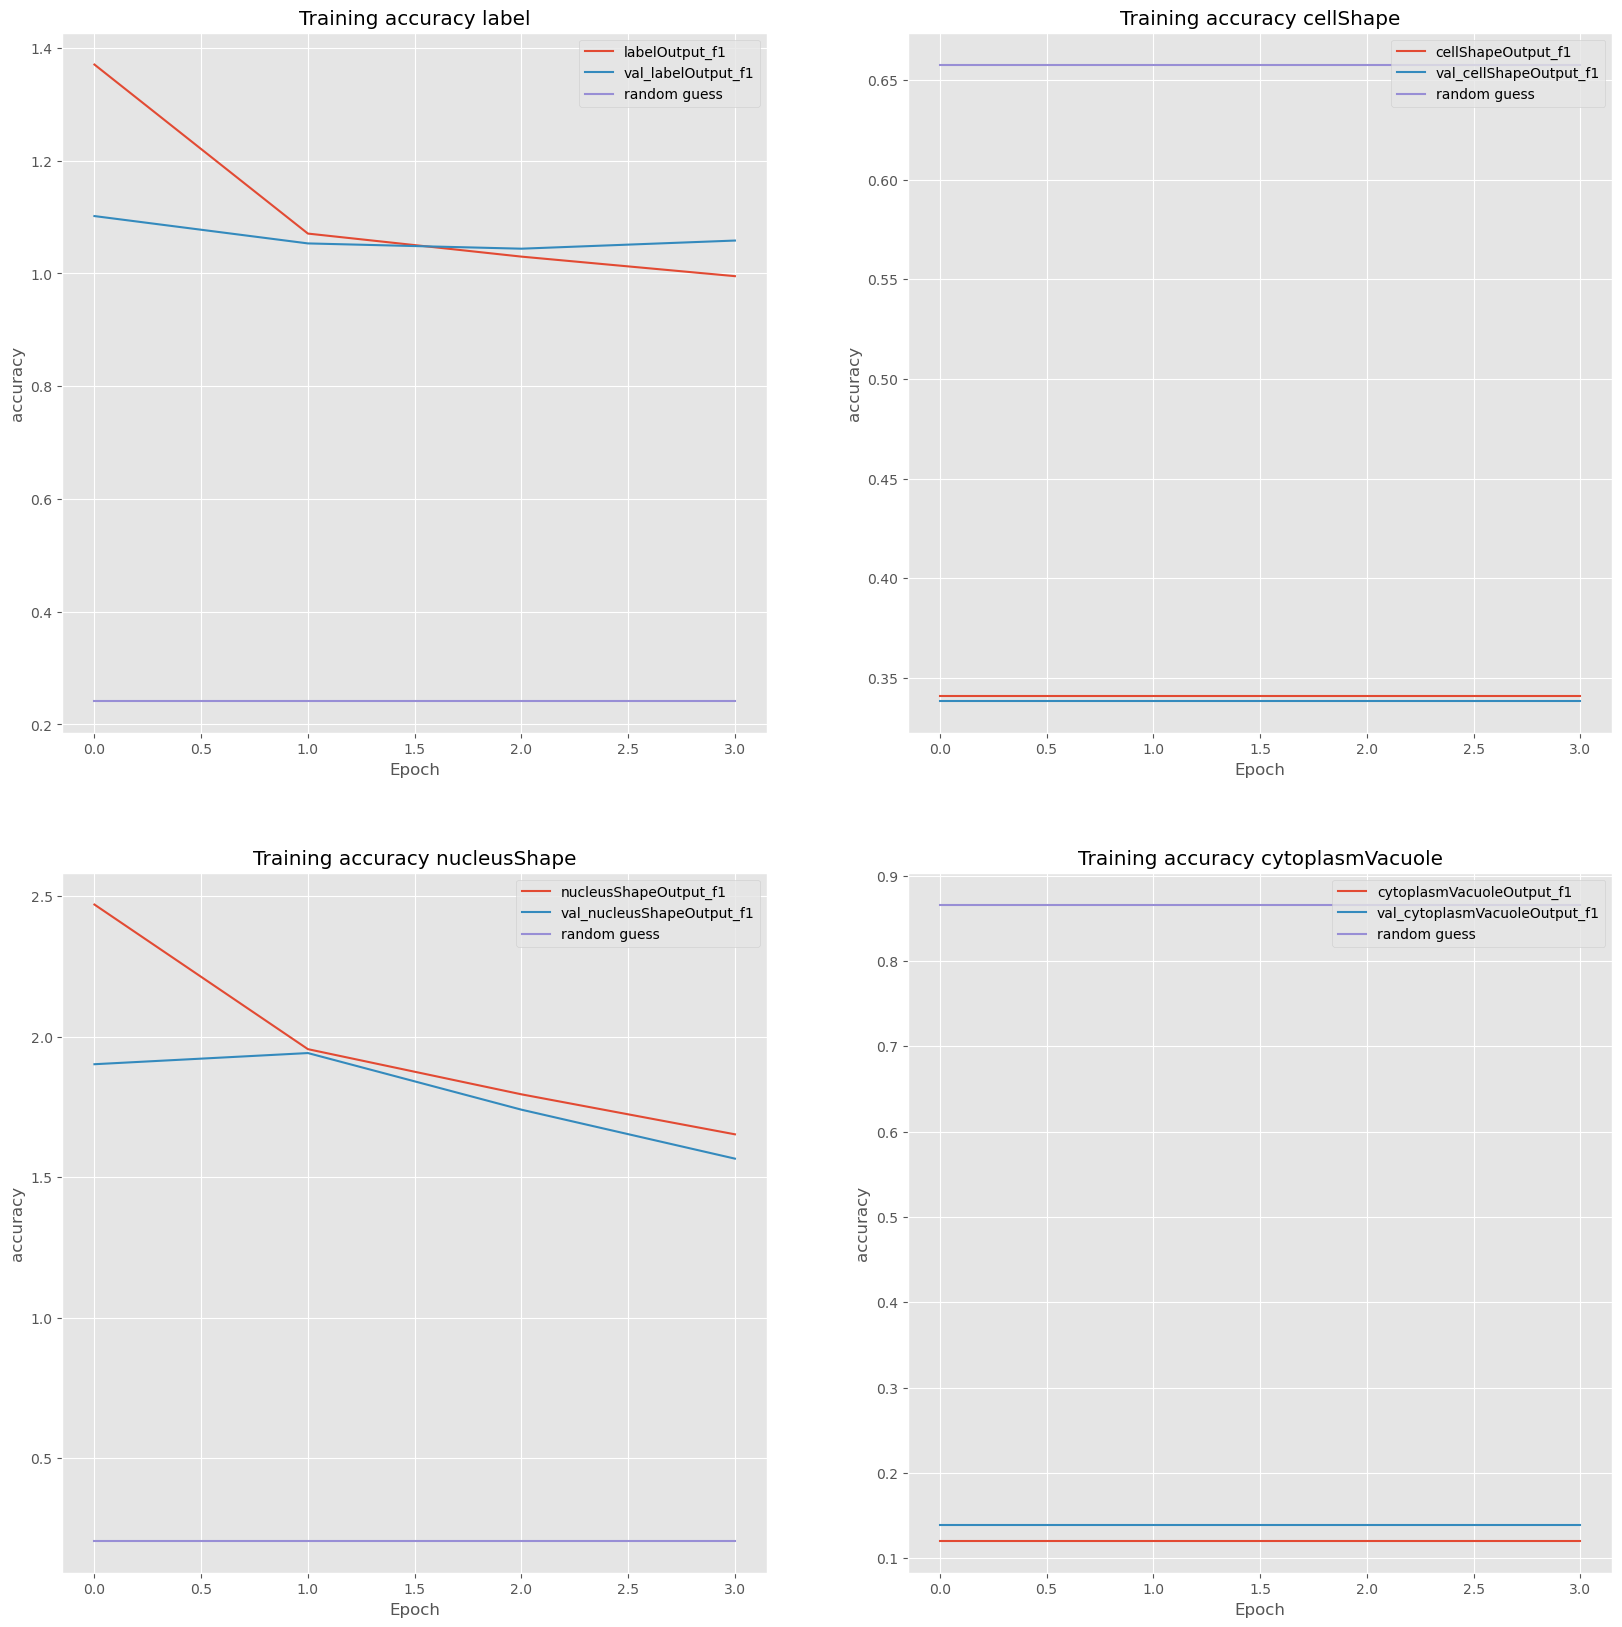

In [51]:
# plot

plt.style.use("ggplot")
plt.figure(figsize=(20,20))
Nepoch=len(history.epoch)

i = 0
for outLabel in ['label', 'cellShape', 'nucleusShape', 'cytoplasmVacuole']:
	i += 1
	plt.subplot(2,2,i)
	trainKey = f'{outLabel}Output_f1'
	testKey = f'val_{trainKey}'
	
	plt.plot(np.arange(0, Nepoch), history.history[trainKey], label=trainKey)

	plt.plot(np.arange(0, Nepoch), history.history[testKey], label=testKey)
	plt.plot(np.arange(0, Nepoch), [classRandomAcc[outLabel] for i in range(Nepoch)], label='random guess')		

	plt.title(f"Training accuracy {outLabel}")
	# plt.ylim(0,1)
	plt.xlabel("Epoch")
	plt.ylabel("accuracy")
	plt.legend(loc="upper right") 

plt.show()
